<a href="https://colab.research.google.com/github/TivoGatto/Thesis/blob/master/InfoVAE/InfoVAE_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# LIBRARIES
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, Dense, Flatten, Reshape, Conv2DTranspose, Lambda
from keras.datasets import cifar10
from keras.callbacks import Callback
import keras.backend as K

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
# Parameters
input_dim = (32, 32, 3)
latent_dim = 128

epochs = 150
batch_size = 100

initial_lr = 1e-4
halve_at_epoch_1 = 80
halve_at_epoch_2 = 120

global alpha
alpha = 1 - 0.024
lam   = 50

TRAIN = False

In [ ]:
# ADDITIONAL FUNCTIONS
def vae_loss(z_mean, z_log_var, z_true, z_gen):
    def loss(x_true, x_pred):
        x_true = K.reshape(x_true, (-1, np.prod(input_dim)))
        x_pred = K.reshape(x_pred, (-1, np.prod(input_dim)))

        xent_loss = 0.5 * K.sum(K.square(x_true - x_pred), axis=-1)
        reg_loss = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=-1) # E_x[DKL(q(z|x) || p(z))]
        mmd_loss = compute_mmd(z_true, z_gen)

        return K.mean(xent_loss + (1 - alpha) * reg_loss) + (alpha + lam - 1) * mmd_loss   # MMD(q(z) || p(z))
    return loss

def recon(x_true, x_pred):
    x_true = K.reshape(x_true, (-1, np.prod(input_dim)))
    x_pred = K.reshape(x_pred, (-1, np.prod(input_dim)))

    return K.mean(0.5 * K.sum(K.square(x_true - x_pred), axis=-1))

def KL(z_mean, z_log_var):
    def loss(x_true, x_pred):
        return K.mean(0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=-1))
    return loss

def mmd_loss(x_true, x_pred):
    return compute_mmd(z_true, z_gen)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))

    return z_mean + epsilon * K.exp(0.5 * z_log_var)

def compute_kernel(x, y):
    x_size = batch_size
    y_size =  x_size

    dim     = K.int_shape(x)[1]
    tiled_x = K.tile(K.reshape(x, K.stack([x_size, 1, dim])), K.stack([1, y_size, 1])) 
    tiled_y = K.tile(K.reshape(y, K.stack([1, y_size, dim])), K.stack([x_size, 1, 1]))
    return K.exp(-K.mean(K.square(tiled_x - tiled_y), axis=2) / K.cast(dim, 'float32'))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)

    return K.mean(x_kernel) + K.mean(y_kernel) - 2 * K.mean(xy_kernel)

In [ ]:
# Dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')/255
x_test  = x_test.astype('float32')/255

print('x_train shape: ' + str(x_train.shape))
print('x_test shape: ' + str(x_test.shape))

170500096/170498071 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)


In [ ]:
# Model Architecture
# ENCODER
x = Input(shape=input_dim) # Shape (32, 32, 3)

h = Conv2D(64, 4, strides=(2, 2), padding='same')(x) # Shape (16, 16, 64)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2D(128, 4, strides=(2, 2), padding='same')(h) # Shape (8, 8, 128)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2D(256, 4, strides=(2, 2), padding='same')(h) # Shape (4, 4, 256)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2D(512, 4, strides=(2, 2), padding='same')(h) # Shape (2, 2, 512)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Flatten()(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling)([z_mean, z_log_var])

encoder = Model(x, [z, z_mean, z_log_var])

# DECODER
z_in = Input(shape=(latent_dim, ))

h = Dense(4 * 4 * 512)(z_in)
h = Reshape((4, 4, 512))(h)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2DTranspose(256, 4, strides=(2, 2), padding='same')(h) # Shape (4, 4, 256)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2DTranspose(128, 4, strides=(2, 2), padding='same')(h) # Shape (8, 8, 128)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2DTranspose(64, 4, strides=(2, 2), padding='same')(h) # Shape (16, 16, 64)
h = BatchNormalization()(h)
h = ReLU()(h)

x_decoded = Conv2DTranspose(3, 4, strides=(1, 1), padding='same', activation='sigmoid')(h)

decoder = Model(z_in, x_decoded)

# Generate z samples
z_true = K.random_normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
z_gen  = encoder(x)[0]

# VAE
x_recon = decoder(z)

vae = Model(x, x_recon)

# Compile the model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
steps_per_epoch = 45000 / batch_size
lr_schedule = PiecewiseConstantDecay([steps_per_epoch * halve_at_epoch_1, steps_per_epoch * halve_at_epoch_2], 
                                     [initial_lr, initial_lr/2, initial_lr/4])
optimizer = Adam(learning_rate=lr_schedule)

vae.compile(optimizer=optimizer, loss=vae_loss(z_mean, z_log_var, z_true, z_gen), metrics=[recon, KL(z_mean, z_log_var)])

In [ ]:
if TRAIN:
  # Fit model
  hist = vae.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

In [ ]:
if TRAIN:
    loss = hist.history['loss']
    recon = hist.history['recon']
    kl = hist.history['loss_1']

    val_loss = hist.history['val_loss']
    val_recon = hist.history['val_recon']
    val_kl = hist.history['val_loss_1']

    from numpy import savetxt
    # save history
    data = np.asarray([loss, recon, kl, val_loss, val_recon, val_kl])
    savetxt('InfoVAE_CIFAR10.csv', data, delimiter=',')

    vae.save_weights('InfoVAE_CIFAR10.h5')
else:
    vae.load_weights('InfoVAE_CIFAR10.h5')

# Generation and Reconstruction

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


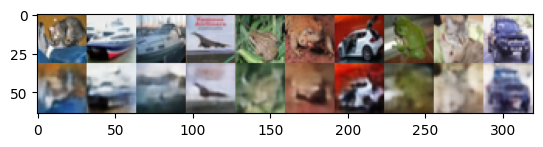

In [ ]:
# Reconstruction

"""
Here we don't need to use the second stage VAE, 'cause we don't use q(z)
"""
n = 10
digit_size = input_dim[0]

x_recon = vae.predict(x_test, batch_size=batch_size)
figure = np.zeros((2 * digit_size, n * digit_size, 3))

for i in range(n):
    figure[:digit_size, i * digit_size: (i+1) * digit_size, :] = x_test[i]
    figure[digit_size:, i * digit_size: (i+1) * digit_size, :] = x_recon[i]

plt.style.use('default')
plt.imshow(figure)
plt.savefig('InfoVAE_CIFAR10_reconstruction.png')
plt.show()

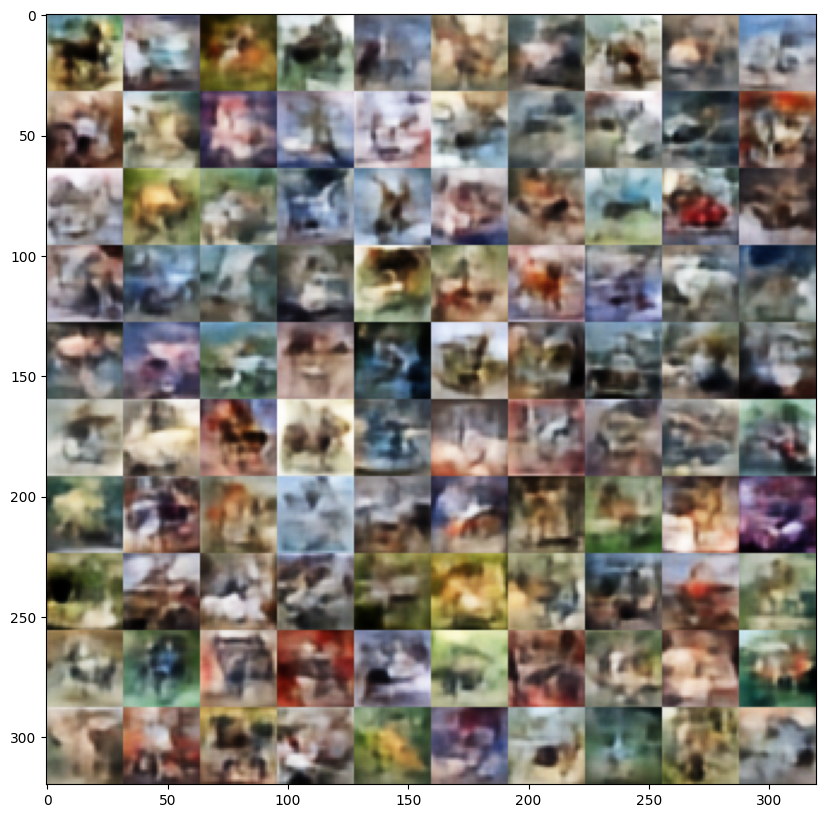

In [ ]:
# Generation
n = 10 #figure with n x n digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n, 3))
# we will sample n points randomly sampled

"""
We want to sample z from q(z) = E_p(u)[q(z|u)]
p(u) = N(0, I)
"""

z_sample = np.random.normal(size=(n**2, latent_dim), scale=1)
for i in range(n):
    for j in range(n):
        x_decoded = decoder.predict(np.array([z_sample[i + n * j]]))
        figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size, :] = x_decoded

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.savefig('InfoVAE_CIFAR10_generation.png')
plt.show()

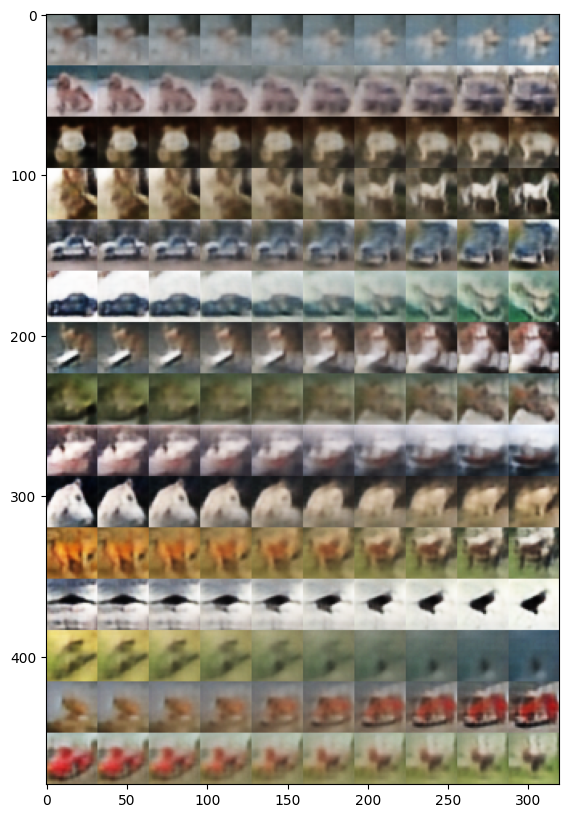

In [ ]:
T = 10
N = 15

s = 10
k = 100

X_final = [0] * N
for n in range(N):
    x_a = x_test[n + s]
    x_b = x_test[n + k]

    z_a = encoder.predict(np.reshape(x_a, (1, 32, 32, 3)))[0]
    z_b = encoder.predict(np.reshape(x_b, (1, 32, 32, 3)))[0]


    X = [0] * T
    for i in range(T):
        t = i/T
        z = t * z_a + (1 - t) * z_b

        X[i] = decoder.predict(z)
    
    X_final[n] = X

digit_size = 32
figure = np.zeros((N * digit_size, T * digit_size, 3))
for n in range(N):
    for i in range(T):
        figure[n * digit_size : (n+1) * digit_size, i * digit_size : (i+1) * digit_size, :] = X_final[n][i][0, :, :, :]

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.savefig('InfoVAE_CIFAR10_interpolation.png')
plt.show()

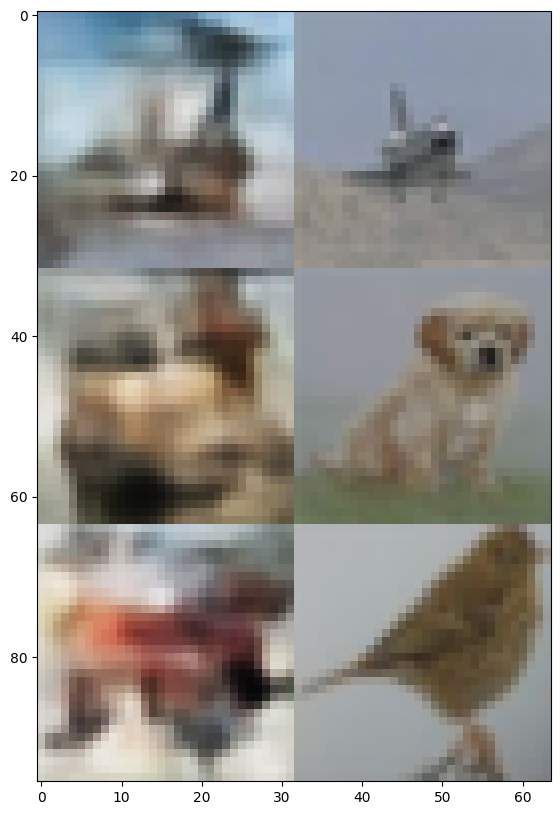

In [ ]:
# We want to investigate overfitting
def get_distance(x, y_vec):
    digit_size = x.shape[0]
    x = np.reshape(x, (digit_size**2*3, ))
    y_vec = np.reshape(y_vec, (-1, digit_size**2*3, ))

    res = np.zeros((y_vec.shape[0], ))
    for j in range(y_vec.shape[0]):
        res[j] = np.mean(np.square(x - y_vec[j]))

    return res

N = 3 # Images we need to check
digit_size = 32
z = np.random.normal(size=(N, latent_dim))
x_gen = decoder.predict(z)
figure = np.zeros((N * digit_size, 2 * digit_size, 3))
for i in range(N):
    x = x_gen[i]
    distances = get_distance(x, x_train)
    m = np.min(distances)
    i_m = np.argmin(distances)

    figure[i * digit_size : (i+1) * digit_size, : digit_size, :] = x
    figure[i * digit_size : (i+1) * digit_size, digit_size :] = x_train[i_m]

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.savefig('InfoVAE_CIFAR10_NN.png')
plt.show()

# Metrics Evaluation

First of all, we want to evaluate the ability of the model of generate high quality samples.

In [ ]:
import numpy as np
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
#from keras.applications.inception_v3 import preprocess_input
#from skimage.transform import resize
#from tensorflow.keras.models import load_model
#import os
#from matplotlib import pyplot

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3), weights='imagenet')

def get_inception_activations(inps, batch_size=100):
    n_batches = inps.shape[0]//batch_size
    act = np.zeros([inps.shape[0], 2048], dtype = np.float32)
    for i in range(n_batches):
        inp = inps[i * batch_size:(i + 1) * batch_size]
        inpr = tf.image.resize(inp, (299, 299))
        act[i * batch_size:(i + 1) * batch_size] = model.predict(inpr,steps=1)
        
        print('Processed ' + str((i+1) * batch_size) + ' images.')
    return act

def get_fid(images1, images2):
    print(images1.shape)
    print(images2.shape)
    print(type(images1))
    # calculate activations
    act1 = get_inception_activations(images1,batch_size=100)
    #print(np.shape(act1))
    act2 = get_inception_activations(images2,batch_size=100)
    # compute mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # compute sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

z_sample = np.random.normal(0, 1, size=(x_test.shape[0], latent_dim))
x_gen = decoder.predict(z_sample)

fid = get_fid(x_test, x_gen)
print('\n FID: %.3f' % fid)

87916544/87910968 [==============================] - 1s 0us/step
(10000, 32, 32, 3)
(10000, 32, 32, 3)
<class 'numpy.ndarray'>
Processed 100 images.
Processed 200 images.
Processed 300 images.
Processed 400 images.
Processed 500 images.
Processed 600 images.
Processed 700 images.
Processed 800 images.
Processed 900 images.
Processed 1000 images.
Processed 1100 images.
Processed 1200 images.
Processed 1300 images.
Processed 1400 images.
Processed 1500 images.
Processed 1600 images.
Processed 1700 images.
Processed 1800 images.
Processed 1900 images.
Processed 2000 images.
Processed 2100 images.
Processed 2200 images.
Processed 2300 images.
Processed 2400 images.
Processed 2500 images.
Processed 2600 images.
Processed 2700 images.
Processed 2800 images.
Processed 2900 images.
Processed 3000 images.
Processed 3100 images.
Processed 3200 images.
Processed 3300 images.
Processed 3400 images.
Processed 3500 images.
Processed 3600 images.
Processed 3700 images.
Processed 3800 images.
Processe

### Deactivated Latent Variables, Variance Loss and Variance Law


In [ ]:
def count_deactivated_variables(z_var, treshold = 0.8):
    z_var = np.mean(z_var, axis=0)

    return np.sum(z_var > treshold)

def loss_variance(x_true, x_recon):
    x_true = np.reshape(x_true, (-1, np.prod(x_true.shape[1:])))
    x_recon = np.reshape(x_recon, (-1, np.prod(x_recon.shape[1:])))

    var_true = np.mean(np.var(x_true, axis=1), axis=0)
    var_recon = np.mean(np.var(x_recon, axis=1), axis=0)

    return np.abs(var_true - var_recon)

########################################################################################################################
# SHOW THE RESULTS
########################################################################################################################

_, z_mean, z_log_var = encoder.predict(x_test, batch_size=batch_size)
z_var = np.exp(z_log_var)
n_deact = count_deactivated_variables(z_var)
print('We have a total of ', latent_dim, ' latent variables. ', count_deactivated_variables(z_var), ' of them are deactivated')

var_law = np.mean(np.var(z_mean, axis=0) + np.mean(z_var, axis=0))
print('Variance law has a value of: ', var_law)

x_recon = vae.predict(x_train, batch_size=batch_size)
print('We lost ', loss_variance(x_test, x_recon), 'Variance of the original data')

We have a total of  128  latent variables.  0  of them are deactivated
Variance law has a value of:  0.991072
We lost  0.00436623 Variance of the original data


### Latent space matching

In [ ]:
# We want to verify if q(z) = p(z).

# Moments Matching
# Generate samples from q(z) and for p(z)
# p(z) = N(0, I)
# q(z) = E_q(x)[q(z|x)]
#
# For every moment we compare the moments
n = len(x_test)

p_samples = np.random.normal(size=(n, latent_dim))
q_samples = encoder.predict(x_test, batch_size=batch_size)[0]


from scipy.stats import moment
# First moment matching:
p_first_moment = np.mean(np.mean(p_samples, axis=0))
q_first_moment = np.mean(np.mean(q_samples, axis=0))

print("\n")
print("First moment of p(z): " + str(p_first_moment))
print("First moment of q(z): " + str(q_first_moment))
print("\n")

# Second moment matching:
p_second_moment = np.mean(np.var(p_samples, axis=0))
q_second_moment = np.mean(np.var(q_samples, axis=0))

print("\n")
print("Second moment of p(z): " + str(p_second_moment))
print("Second moment of q(z): " + str(q_second_moment))
print("\n")

# Thid moment matching:
p_third_moment = np.mean(moment(p_samples, moment=3, axis=0))
q_third_moment = np.mean(moment(q_samples, moment=3, axis=0))

print("\n")
print("Third moment of p(z): " + str(p_third_moment))
print("Third moment of q(z): " + str(q_third_moment))
print("\n")



First moment of p(z): 0.0006527952077534666
First moment of q(z): -0.002492536




Second moment of p(z): 1.0019908042570025
Second moment of q(z): 0.9924074




Third moment of p(z): -0.00171536368614917
Third moment of q(z): 0.004764896




In [ ]:
# To verify that q(z) = p(z) we can also use MMD

def compute_kernel(x, y):
    return np.exp(-np.mean(np.square(x - y), axis=-1))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)

    return np.mean(x_kernel) + np.mean(y_kernel) - 2 * np.mean(xy_kernel) 

z_p = np.random.normal(size=(len(x_test), latent_dim))
z_q = encoder.predict(x_test, batch_size=batch_size)[0]  # sample from q(z)

z_p = z_p.astype('float32')
z_q = z_q.astype('float32')

mmd = compute_mmd(z_p, z_q)
print('MMD between p(z) and q(z) is ' + str(mmd))

MMD between p(z) and q(z) is 1.7109621465206146
